In [ ]:
cd drive/MyDrive/H2TProject/

/content/drive/MyDrive/H2TProject


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

In [ ]:
images = []
labels = []

RECORDS_COUNT = 30000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [ ]:
with open('./iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents]
lines[-1]

'b06-110-07-03 ok 173 987 2031 8 6 . .'

In [ ]:
def process_image(img):
    h, w = img.shape
    new_h = 32
    new_w = int(w * (new_h / h))
    img = cv2.resize(img, (new_w, new_h))
    h, w = img.shape

    img = img.astype('float32')

    if h < 32:
        add_zeros = np.full((32-h, w), 255)
        img = np.concatenate((img, add_zeros))
        h, w = img.shape

    if w < 128:
        add_zeros = np.full((h, 128-w), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        h, w = img.shape

    if w > 128 or h > 32:
        dim = (128, 32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    img = img / 255

    return img

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_to_labels(txt):
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = './iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)

        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break




In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
def cnn_rnn_model():
    inputs = Input(shape=(32, 128, 1))

    conv_1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_2)
    batch_norm_3 = BatchNormalization()(conv_3)
    pool_3 = MaxPool2D(pool_size=(2, 1))(batch_norm_3)

    conv_4 = Conv2D(512, (3,3), activation='relu', padding='same')(pool_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    squeezed = Lambda(lambda x: tf.squeeze(x, axis=1))(batch_norm_4)

    lstm_1 = LSTM(256, return_sequences=True, dropout=0.2)(squeezed)

    outputs = Dense(79, activation='softmax')(lstm_1)

    model_1 = Model(inputs, outputs)

    return model_1, outputs, inputs

In [ ]:
model_1,outputs,inputs=cnn_rnn_model()

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 5
epochs = 25
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath = "{optimizer}_{records}_{epochs}_{train}_{valid}.keras".format(optimizer=optimizer_name,records=RECORDS_COUNT,epochs=epochs,train=train_images.shape[0],valid=valid_images.shape[0])
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0018 - loss: 15.7096
Epoch 1: val_accuracy improved from -inf to 0.05580, saving model to sgdo-30000r-25e-18074t-2007v.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


3615/3615 ━━━━━━━━━━━━━━━━━━━━ 101s 26ms/step - accuracy: 0.0018 - loss: 15.7092 - val_accuracy: 0.0558 - val_loss: 12.0007
Epoch 2/25
3613/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0583 - loss: 11.3714
Epoch 2: val_accuracy improved from 0.05580 to 0.11211, saving model to sgdo-30000r-25e-18074t-2007v.keras
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 133s 25ms/step - accuracy: 0.0583 - loss: 11.3706 - val_accuracy: 0.1121 - val_loss: 9.3799
Epoch 3/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1382 - loss: 7.7877
Epoch 3: val_accuracy improved from 0.11211 to 0.17688, saving model to sgdo-30000r-25e-18074t-2007v.keras
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 144s 25ms/step - accuracy: 0.1382 - loss: 7.7874 - val_accuracy: 0.1769 - val_loss: 5.8652
Epoch 4/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2521 - loss: 4.7282
Epoch 4: val_accuracy improved from 0.17688 to 0.28301, saving model to sgdo-30000r-25e-18074t-2007v.keras
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
original_text =   to
predicted text = to

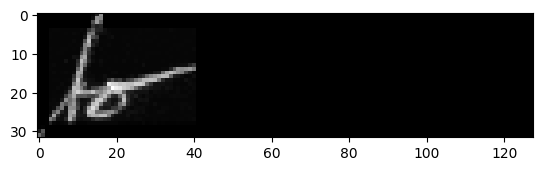



original_text =   Welensky
predicted text = Wielensky

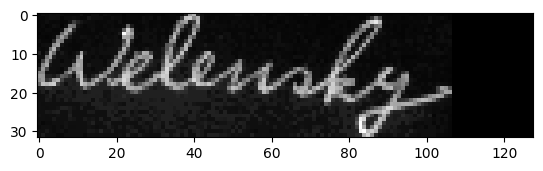



original_text =   Labour
predicted text = Labour

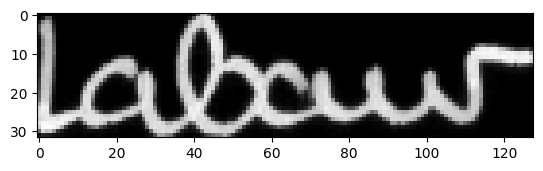



original_text =   Labour
predicted text = Labour

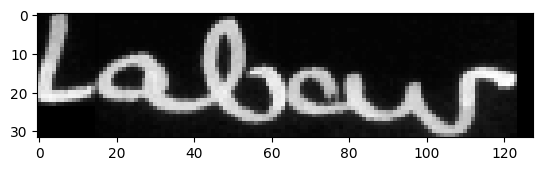



original_text =   of
predicted text = of

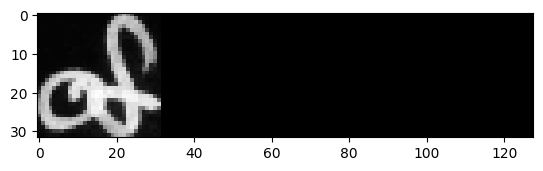

In [ ]:
i=35
j=40
prediction = model_1.predict(valid_images[i:j])

decoded = tf.keras.backend.ctc_decode(
    prediction,
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True)[0][0]

out = tf.keras.backend.get_value(decoded)


for _, x in enumerate(out):

    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')